# Предсказание риска сердечных приступов

**Описание**: В проекте разрабатывается модель машинного обучения для предсказания риска сердечных приступов на основе анкетных, биохимических и медицинских данных пациентов. Пайплайн с обученной моделью сохраняется в artifacts/heart_risk_model.pkl для дальнейшего использования в сервисе. 


**Цели**: 
- Провести исследовательский анализ данных для выявления закономерностей и проблемных признаков.  
- Подготовить данные для обучения модели: очистка, обработка пропусков, преобразование типов, работа с коррелированными признаками.  
- Обучить и оценить модель машинного обучения для предсказания риска сердечных приступов.  
- Сохранить обученную модель для последующего использования в отдельном сервисе.  

**Исходные данные:**
- Антропометрические параметры: вес, рост, возраст
- Привычки: курение, качество сна и т.д.
- Давление
- Наличие хронических заболеваний
- Биохимия крови
- Целевой признак: высокий/низкий риск сердечного приступа

In [1]:
import os
from pathlib import Path
from contextlib import contextmanager
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML, Markdown
import phik
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from catboost import CatBoostClassifier
import dill

warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', None)

RANDOM_STATE = 42
TEST_SIZE = 0.25

## Загрузка данных

Создадим вспомогательные фукнции для импорта и просмотра данных

In [2]:
def to_snake_case(df: pd.DataFrame) -> pd.DataFrame:
    df.columns = df.columns.str.strip().str.replace(r'[ \-]', '_', regex=True).str.replace(r'[\(\)]', '', regex=True).str.lower()
    return df

In [3]:
PATH_PREFIXES = ('./datasets', 'https://code.s3.yandex.net/datasets', '/datasets')

def import_df(table_name: str, sep: str = ';', decimal: str = '.') -> pd.DataFrame:
    for path_prefix in PATH_PREFIXES:
        try:
            return to_snake_case(pd.read_csv(os.path.join(path_prefix, table_name), sep=sep, decimal=decimal))
        except Exception:
            continue
    print(f'File {table_name} not found')

In [4]:
def df_info(df: pd.DataFrame) -> None:
    display(Markdown('**Размер датафрейма**'), df.shape)
    display(Markdown('**Информация о датафрейме**'))
    df.info()
    display(Markdown(f'**Количество явных дубликатов строк: {df.duplicated().sum()}**'))
    display(Markdown(f'**Общее количество пропущенных значений: {df.isna().sum().sum()}**'))
    display(Markdown('**Первые строки датафрейма**'), df.head())

Импортируем данные

Тренировочный датасет

In [5]:
train_df = import_df('heart_train.csv', sep=',')

In [6]:
df_info(train_df)

**Размер датафрейма**

(8685, 28)

**Информация о датафрейме**

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8685 entries, 0 to 8684
Data columns (total 28 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   unnamed:_0                       8685 non-null   int64  
 1   age                              8685 non-null   float64
 2   cholesterol                      8685 non-null   float64
 3   heart_rate                       8685 non-null   float64
 4   diabetes                         8442 non-null   float64
 5   family_history                   8442 non-null   float64
 6   smoking                          8442 non-null   float64
 7   obesity                          8442 non-null   float64
 8   alcohol_consumption              8442 non-null   float64
 9   exercise_hours_per_week          8685 non-null   float64
 10  diet                             8685 non-null   int64  
 11  previous_heart_problems          8442 non-null   float64
 12  medication_use      

**Количество явных дубликатов строк: 0**

**Общее количество пропущенных значений: 2187**

**Первые строки датафрейма**

,unnamed:_0,age,cholesterol,heart_rate,diabetes,family_history,smoking,obesity,alcohol_consumption,exercise_hours_per_week,diet,previous_heart_problems,medication_use,stress_level,sedentary_hours_per_day,income,bmi,triglycerides,physical_activity_days_per_week,sleep_hours_per_day,heart_attack_risk_binary,blood_sugar,ck_mb,troponin,gender,systolic_blood_pressure,diastolic_blood_pressure,id
0,0,0.359551,0.732143,0.074244,1.0,1.0,1.0,1.0,1.0,0.535505,1,1.0,0.0,8.0,0.225704,0.105948,0.459176,0.979221,3.0,0.333333,0.0,0.227018,0.048229,0.036512,Male,0.212903,0.709302,2664
1,1,0.202247,0.325000,0.047663,1.0,1.0,0.0,0.0,1.0,0.068690,2,1.0,0.0,9.0,0.289923,0.164217,0.117053,0.515584,3.0,0.833333,0.0,0.150198,0.017616,0.000194,Female,0.412903,0.569767,9287
2,2,0.606742,0.860714,0.055912,1.0,0.0,1.0,1.0,1.0,0.944001,2,1.0,1.0,6.0,0.550133,0.598745,0.373574,0.012987,2.0,1.000000,0.0,0.227018,0.048229,0.036512,Female,0.238710,0.220930,5379
3,3,0.730337,0.007143,0.053162,0.0,0.0,1.0,0.0,1.0,0.697023,0,0.0,1.0,3.0,0.330962,0.077605,0.049735,0.131169,0.0,0.333333,1.0,0.227018,0.048229,0.036512,Female,0.348387,0.267442,8222
4,4,0.775281,0.757143,0.021998,0.0,0.0,1.0,0.0,1.0,0.412878,1,0.0,0.0,8.0,0.524600,0.341960,0.830405,0.070130,5.0,1.000000,1.0,0.227018,0.048229,0.036512,Male,0.619355,0.441860,4047


Тестовый датасет

In [7]:
test_df = import_df('heart_test.csv', sep=',')

In [8]:
df_info(test_df)

**Размер датафрейма**

(966, 27)

**Информация о датафрейме**

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 966 entries, 0 to 965
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   unnamed:_0                       966 non-null    int64  
 1   age                              966 non-null    float64
 2   cholesterol                      966 non-null    float64
 3   heart_rate                       966 non-null    float64
 4   diabetes                         935 non-null    float64
 5   family_history                   935 non-null    float64
 6   smoking                          935 non-null    float64
 7   obesity                          935 non-null    float64
 8   alcohol_consumption              935 non-null    float64
 9   exercise_hours_per_week          966 non-null    float64
 10  diet                             966 non-null    int64  
 11  previous_heart_problems          935 non-null    float64
 12  medication_use        

**Количество явных дубликатов строк: 0**

**Общее количество пропущенных значений: 279**

**Первые строки датафрейма**

,unnamed:_0,age,cholesterol,heart_rate,diabetes,family_history,smoking,obesity,alcohol_consumption,exercise_hours_per_week,diet,previous_heart_problems,medication_use,stress_level,sedentary_hours_per_day,income,bmi,triglycerides,physical_activity_days_per_week,sleep_hours_per_day,blood_sugar,ck_mb,troponin,gender,systolic_blood_pressure,diastolic_blood_pressure,id
0,0,0.494382,0.264286,0.062328,0.0,1.0,1.0,1.0,1.0,0.361618,2,0.0,0.0,8.0,0.194370,0.587759,0.283490,0.306494,1.0,0.333333,0.227018,0.048229,0.036512,Male,0.283871,0.372093,7746
1,1,0.224719,0.953571,0.082493,1.0,0.0,0.0,1.0,0.0,0.996483,2,1.0,1.0,5.0,0.329888,0.602883,0.467036,0.087013,0.0,0.166667,0.227018,0.048229,0.036512,Female,0.703226,0.441860,4202
2,2,0.629213,0.092857,0.064161,0.0,1.0,1.0,1.0,0.0,0.995561,0,0.0,0.0,10.0,0.780075,0.370436,0.409366,0.205195,7.0,1.000000,0.102767,0.002666,0.088455,Male,0.458065,0.779070,6632
3,3,0.460674,0.567857,0.055912,1.0,1.0,1.0,1.0,1.0,0.437277,0,0.0,0.0,10.0,0.785071,0.368242,0.910261,0.163636,0.0,0.666667,0.203557,0.056390,0.271774,Female,0.741935,0.255814,4639
4,4,0.719101,0.485714,0.022915,1.0,0.0,1.0,0.0,1.0,0.514920,0,0.0,0.0,7.0,0.070919,0.729578,0.758924,0.580519,5.0,0.000000,0.227018,0.048229,0.036512,Male,0.412903,0.395349,4825


Предположительные значения признаков.
- `unnamed:_0` не несет полезной информации, представляет из себя нумерацию строк в исходных данных (удалим)
- `age` возраст пациента
- `cholesterol` уровень холестерина
- `heart_rate` частота сердечных сокращений
- `diabetes` наличие диабета у пациента
- `family_history` наличие сердечно-сосудистых заболеваний в семье
- `smoking` курит ли пациент
- `obesity` имеется ли у пациента ожирение
- `alcohol_consumption` употребление алкоголя
- `exercise_hours_per_week` количество часов физической активности в неделю
- `diet` оценка качества питания
- `previous_heart_problems` наличие сердечных заболеваний в прошлом
- `medication_use` признак приема пациентом лекарств
- `stress_level` уровень стресса
- `sedentary_hours_per_day` сколько часов пациент сидит в день
- `income` может означать доход пациента. Под вопросом.
- `bmi` индекс массы тела
- `triglycerides` уровень триглицеридов в крови
- `physical_activity_days_per_week` количество дней с физической активностью в неделю
- `sleep_hours_per_day` средняя продолжительность сна в сутки
- `blood_sugar` уровень сахара в крови
- `ck_mb` фермент сердца, показатель повреждения сердечной мышцы. Анализ проводится при подозрении на инфаркт миокарда или отслеживании состояния при уже случившемся инфаркте. **Утечка целевого признака (удалим).**
- `troponin` белок-тропонин, маркер инфаркта. **Утечка целевого признака (удалим)**
- `gender` пол пациента
- `systolic_blood_pressure` систолическое давление
- `diastolic_blood_pressure` диастолическое давление
- `id` идентификатор пациента
- `heart_attack_risk_binary` признак высокого или низкого риска поражения сердца (целевой признак)

Удалим признаки `unnamed:_0`, `ck_mb` и `troponin`


In [9]:
train_df = train_df.drop(columns=['unnamed:_0', 'ck_mb', 'troponin'])

Объявим переменные с числовыми. категориальными и целевым признаками

In [10]:
cat_features = [
    'gender',
    'diabetes',
    'family_history',
    'smoking',
    'obesity',
    'alcohol_consumption',
    'diet',
    'previous_heart_problems',
    'medication_use',
    'stress_level',
    'physical_activity_days_per_week',
]
num_features = [
    'age',
    'blood_sugar',
    'bmi',
    'cholesterol',
    'diastolic_blood_pressure',
    'exercise_hours_per_week',
    'heart_rate',
    'income',
    'sedentary_hours_per_day',
    'systolic_blood_pressure',
    'triglycerides',
    'sleep_hours_per_day',
]
target = 'heart_attack_risk_binary'

Убедимся, что не упустили ни одну из колонок из виду

In [11]:
set(train_df.columns) - set(cat_features + num_features + [target])

{'id'}

**Тренирвочный датасет содержит 8685 строк, тестовый 966 строк. Из тренировочного датасета удалены признаки `unnamed:_0` (не несет полезной информации), `ck_mb` и `troponin` (утечка целевого признака). Тестовая выборка не содержит целевой признак.**

## Предобработка данных

In [12]:
df_info(train_df)

**Размер датафрейма**

(8685, 25)

**Информация о датафрейме**

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8685 entries, 0 to 8684
Data columns (total 25 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   age                              8685 non-null   float64
 1   cholesterol                      8685 non-null   float64
 2   heart_rate                       8685 non-null   float64
 3   diabetes                         8442 non-null   float64
 4   family_history                   8442 non-null   float64
 5   smoking                          8442 non-null   float64
 6   obesity                          8442 non-null   float64
 7   alcohol_consumption              8442 non-null   float64
 8   exercise_hours_per_week          8685 non-null   float64
 9   diet                             8685 non-null   int64  
 10  previous_heart_problems          8442 non-null   float64
 11  medication_use                   8442 non-null   float64
 12  stress_level        

**Количество явных дубликатов строк: 0**

**Общее количество пропущенных значений: 2187**

**Первые строки датафрейма**

,age,cholesterol,heart_rate,diabetes,family_history,smoking,obesity,alcohol_consumption,exercise_hours_per_week,diet,previous_heart_problems,medication_use,stress_level,sedentary_hours_per_day,income,bmi,triglycerides,physical_activity_days_per_week,sleep_hours_per_day,heart_attack_risk_binary,blood_sugar,gender,systolic_blood_pressure,diastolic_blood_pressure,id
0,0.359551,0.732143,0.074244,1.0,1.0,1.0,1.0,1.0,0.535505,1,1.0,0.0,8.0,0.225704,0.105948,0.459176,0.979221,3.0,0.333333,0.0,0.227018,Male,0.212903,0.709302,2664
1,0.202247,0.325000,0.047663,1.0,1.0,0.0,0.0,1.0,0.068690,2,1.0,0.0,9.0,0.289923,0.164217,0.117053,0.515584,3.0,0.833333,0.0,0.150198,Female,0.412903,0.569767,9287
2,0.606742,0.860714,0.055912,1.0,0.0,1.0,1.0,1.0,0.944001,2,1.0,1.0,6.0,0.550133,0.598745,0.373574,0.012987,2.0,1.000000,0.0,0.227018,Female,0.238710,0.220930,5379
3,0.730337,0.007143,0.053162,0.0,0.0,1.0,0.0,1.0,0.697023,0,0.0,1.0,3.0,0.330962,0.077605,0.049735,0.131169,0.0,0.333333,1.0,0.227018,Female,0.348387,0.267442,8222
4,0.775281,0.757143,0.021998,0.0,0.0,1.0,0.0,1.0,0.412878,1,0.0,0.0,8.0,0.524600,0.341960,0.830405,0.070130,5.0,1.000000,1.0,0.227018,Male,0.619355,0.441860,4047


Убедимся в отсутствии дубликатов `id`

In [13]:
train_df['id'].duplicated().sum()

0

Изучим уникальные значения в категориальных колонках и целевом признаке на тренировочной выборке

In [14]:
for col in cat_features + [target]:
    print(col, train_df[col].unique())

gender ['Male' 'Female' '1.0' '0.0']
diabetes [ 1.  0. nan]
family_history [ 1.  0. nan]
smoking [ 1.  0. nan]
obesity [ 1.  0. nan]
alcohol_consumption [ 1.  0. nan]
diet [1 2 0 3]
previous_heart_problems [ 1.  0. nan]
medication_use [ 0.  1. nan]
stress_level [ 8.  9.  6.  3.  7.  1. 10. nan  2.  5.  4.]
physical_activity_days_per_week [ 3.  2.  0.  5.  6.  4.  7. nan  1.]
heart_attack_risk_binary [0. 1.]


В колонке `gender` пол указан как в виде Male/Female, так и как 1/0. Рассмотрим значения этой колонки подробней.

In [15]:
train_df['gender'].value_counts()

gender
Male      5882
Female    2560
1.0        156
0.0         87
Name: count, dtype: int64

С высокой вероятностью под 1 закодирован мужской пол, а под 0 женский.

Изучим уникальные значения в категориальных колонках и целевом признаке на тестовой выборке

In [16]:
for col in cat_features:
    print(col, test_df[col].unique())

gender ['Male' 'Female' '1.0' '0.0']
diabetes [ 0.  1. nan]
family_history [ 1.  0. nan]
smoking [ 1.  0. nan]
obesity [ 1.  0. nan]
alcohol_consumption [ 1.  0. nan]
diet [2 0 1 3]
previous_heart_problems [ 0.  1. nan]
medication_use [ 0.  1. nan]
stress_level [ 8.  5. 10.  7.  1.  4.  9.  6.  3. nan  2.]
physical_activity_days_per_week [ 1.  0.  7.  5.  3.  2.  4.  6. nan]


Уникальные значения категориальных признаков на тестовой и тренировочной выборках совпадают.

Рассмотрим пропущенные значения

In [17]:
train_df.isna().mean().sort_values(ascending=False)

stress_level                       0.027979
diabetes                           0.027979
family_history                     0.027979
smoking                            0.027979
obesity                            0.027979
alcohol_consumption                0.027979
previous_heart_problems            0.027979
medication_use                     0.027979
physical_activity_days_per_week    0.027979
triglycerides                      0.000000
diastolic_blood_pressure           0.000000
systolic_blood_pressure            0.000000
gender                             0.000000
blood_sugar                        0.000000
heart_attack_risk_binary           0.000000
sleep_hours_per_day                0.000000
age                                0.000000
bmi                                0.000000
income                             0.000000
sedentary_hours_per_day            0.000000
cholesterol                        0.000000
diet                               0.000000
exercise_hours_per_week         

Заметим, что у всех колонок с пропущенными значениями одинаковая доля пропущенных значений. Вероятно, в каждой строке либо вовсе нет пропущенных значений, либо они наблюдаются одновременно у определенного набора признаков. Убедимся в этом.

In [18]:
train_df[train_df['stress_level'].notna()].isna().mean().sort_values(ascending=False)

age                                0.0
sedentary_hours_per_day            0.0
diastolic_blood_pressure           0.0
systolic_blood_pressure            0.0
gender                             0.0
blood_sugar                        0.0
heart_attack_risk_binary           0.0
sleep_hours_per_day                0.0
physical_activity_days_per_week    0.0
triglycerides                      0.0
bmi                                0.0
income                             0.0
stress_level                       0.0
cholesterol                        0.0
medication_use                     0.0
previous_heart_problems            0.0
diet                               0.0
exercise_hours_per_week            0.0
alcohol_consumption                0.0
obesity                            0.0
smoking                            0.0
family_history                     0.0
diabetes                           0.0
heart_rate                         0.0
id                                 0.0
dtype: float64

**Убедились в отсутствии дубликатов. В колонке `gender` значения могут приходить как в виде `'Male'` / `'Female'`, так и `'1.0'` / `'0.0'`. Будет преобразовано в пайплайне к виду 1 / 0. Остальные категориальные колонки имеют неподходящие типы - целые числа сохранены как числа с плавающей точкой. Будет приведено к целым числам в пайплайне.**

**Поскольку планируется использование Catboost, способного работать с пропущенными значеними, необходимости в обработке пропусков нет. Для категориальных колонок все значения будут приведены к строкам (после приведения к целым типам), а пропущенные значения к строкам `'nan'` (согласно документации Catboost, строка `'nan'` воспринимается как пропущенное значение)**

## Исследовательский анализ

### Числовые признаки

In [19]:
train_df[num_features].describe().T

,count,mean,std,min,25%,50%,75%,max
age,8685.0,0.449958,0.231174,0.0,0.258427,0.460674,0.640449,1.0
blood_sugar,8685.0,0.227339,0.076635,0.0,0.227018,0.227018,0.227018,1.0
bmi,8685.0,0.496774,0.282561,0.0,0.254190,0.494774,0.736974,1.0
cholesterol,8685.0,0.501070,0.284716,0.0,0.267857,0.499780,0.746429,1.0
diastolic_blood_pressure,8685.0,0.497634,0.171830,0.0,0.348837,0.500000,0.651163,1.0
exercise_hours_per_week,8685.0,0.503378,0.284810,0.0,0.263286,0.502110,0.748709,1.0
heart_rate,8685.0,0.050658,0.023453,0.0,0.034830,0.050412,0.065995,1.0
income,8685.0,0.496055,0.284698,0.0,0.251922,0.494889,0.741036,1.0
sedentary_hours_per_day,8685.0,0.499164,0.285340,0.0,0.255875,0.499920,0.744623,1.0
systolic_blood_pressure,8685.0,0.450295,0.170184,0.0,0.303226,0.445161,0.600000,1.0


Видим, что все числовые признаки уже нормализованы и находятся в диапазоне от 0 до 1

Создадим вспомогательную функции для отрисовки гистограммы и боксплота

In [20]:
def draw_hist_and_box(df, col, target):
    fig, axes = plt.subplots(1, 2, figsize=(12, 2.5))

    sns.histplot(
        data=df,
        x=col,
        hue=target,
        bins=30,
        stat='density',
        common_norm=False,
        element='step',
        ax=axes[0]
    )
    axes[0].set_title(f'{col} — hist')

    sns.boxplot(
        data=df,
        x=col,
        orient='h',
        ax=axes[1]
    )
    axes[1].set_title(f'{col} — box')

    plt.tight_layout()
    plt.show()

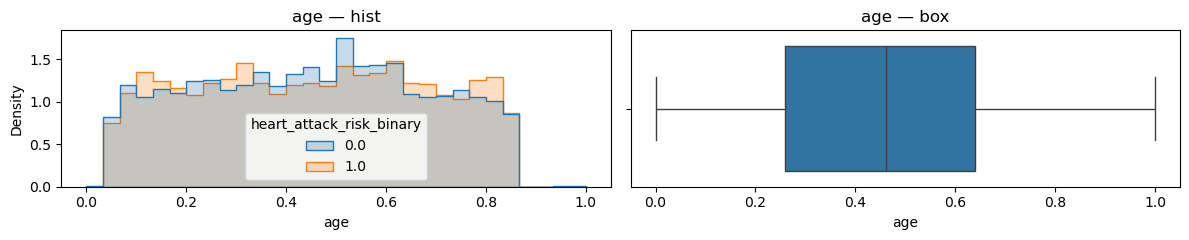

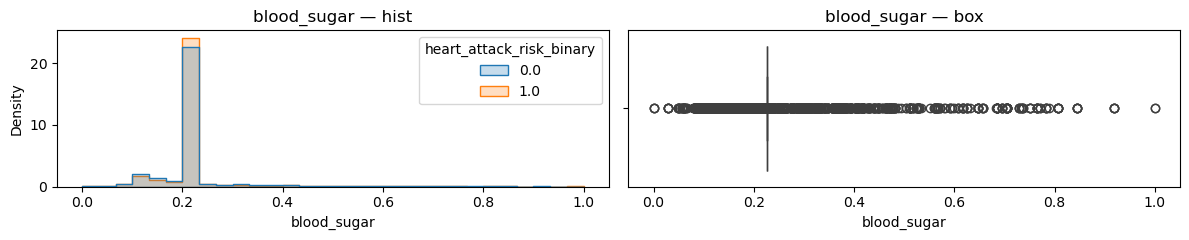

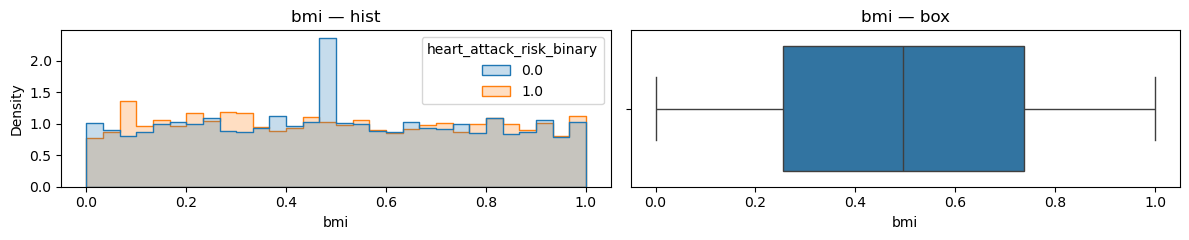

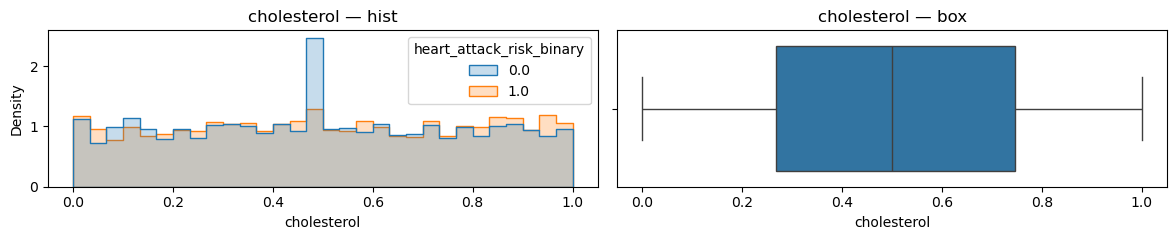

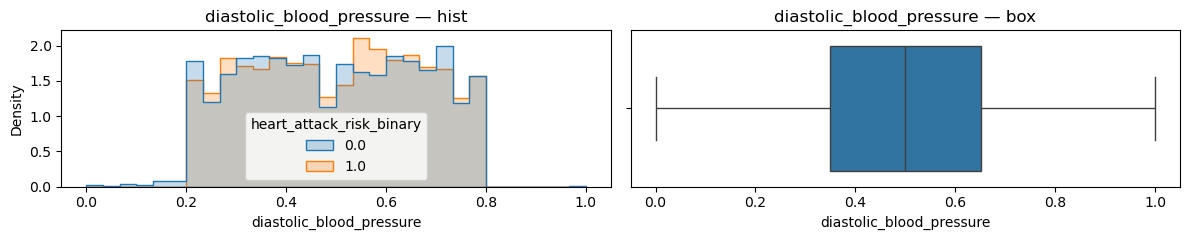

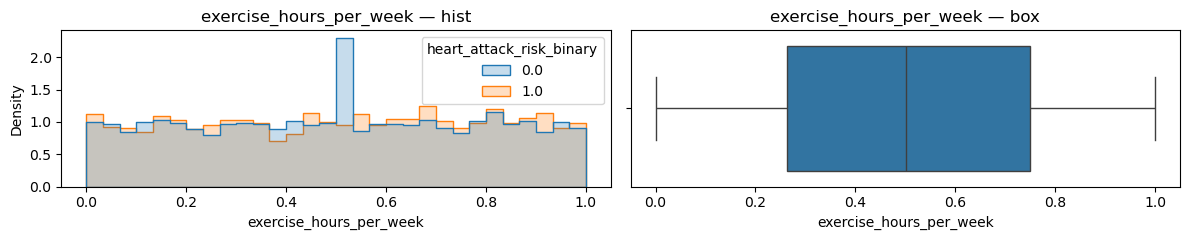

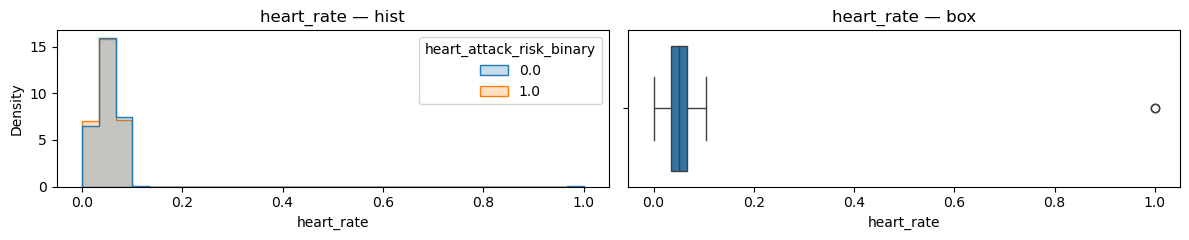

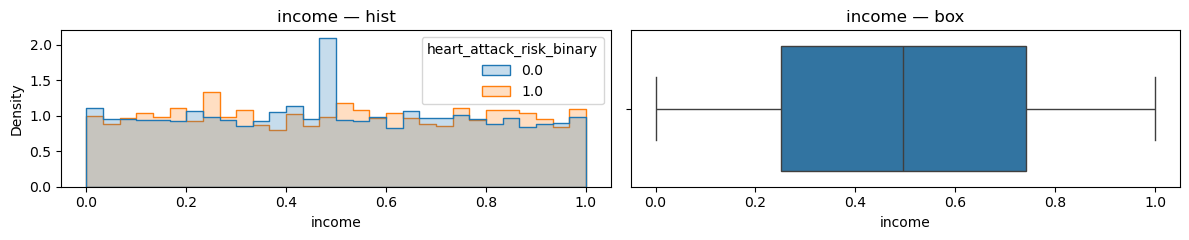

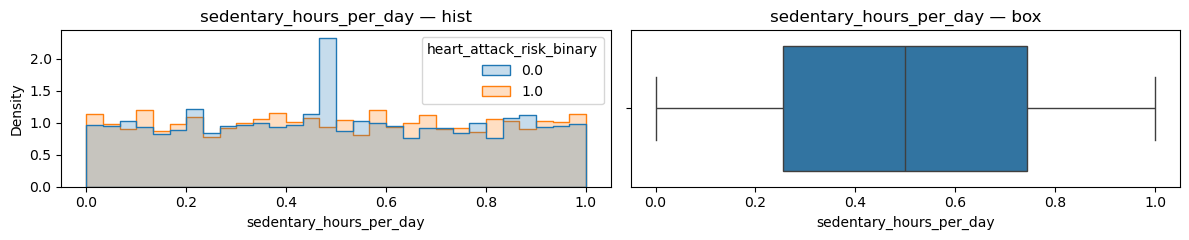

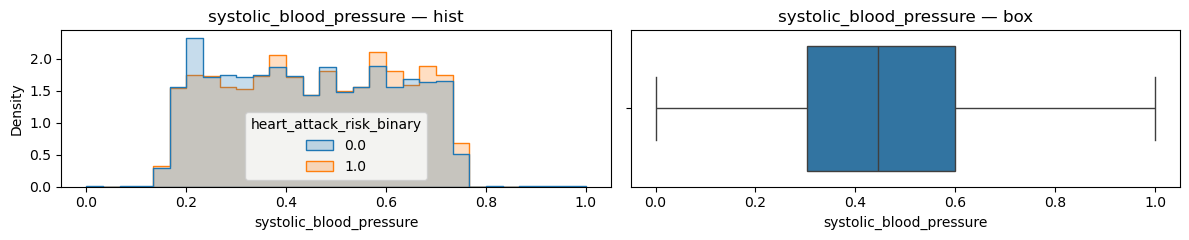

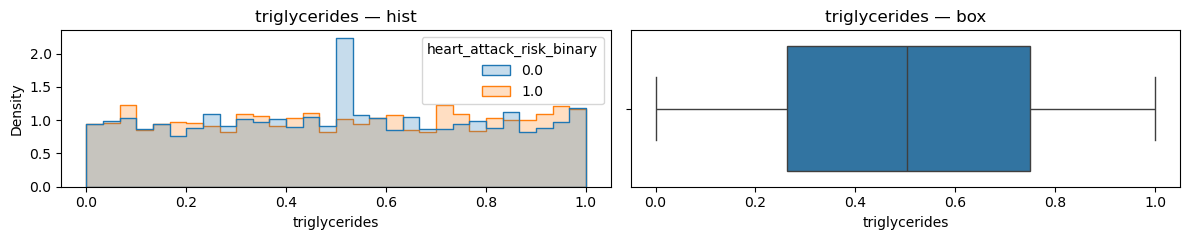

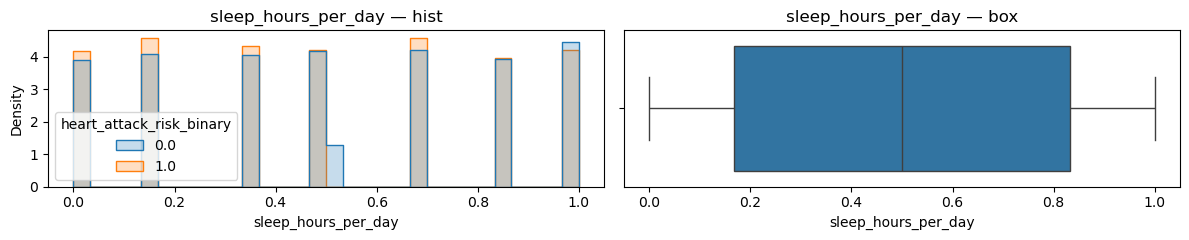

In [21]:
for col in num_features:
    draw_hist_and_box(train_df, col, target)

Изучив гистограммы, можем заметить, что соответствие признаков `bmi`,  `cholesterol`, `exercise_hours_per_week`, `income`, `sedentary_hours_per_day` и `triglycerides` определенному узкому диапазону значений (предположительно, норме здорового человека), является признаком более низкой вероятности сердечного приступа.

Можем наблюдать выбросы в признаках `heart_rate` и `blood_sugar`

Рассмотрим `heart_rate`

In [22]:
train_df[train_df['heart_rate'] > 0.8].shape[0]

2

Имеем всего две строки с выбросами `heart_rate`, удалим их

In [23]:
@contextmanager
def print_shape():
    print(f'Строк до удаления: {train_df.shape[0]}')
    yield
    print(f'Строк после удаления: {train_df.shape[0]}')

In [24]:
with print_shape():
    train_df = train_df[train_df['heart_rate'] < 0.8]

Строк до удаления: 8685
Строк после удаления: 8683


Повторно рассмотрим гистограмму и боксплот признака `heart_rate`

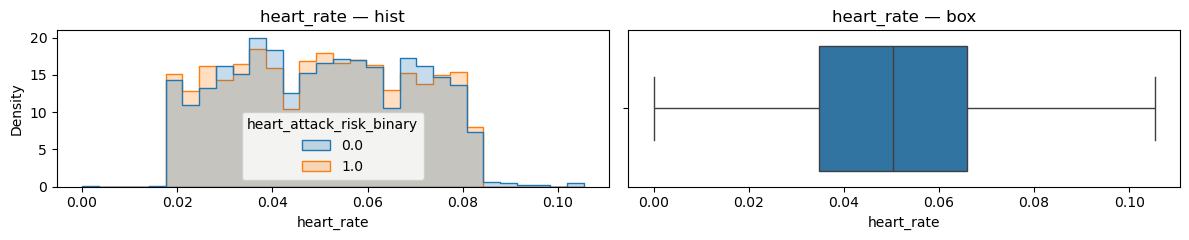

In [25]:
draw_hist_and_box(train_df, 'heart_rate', target)

Рассмотрим `blood_sugar`

In [26]:
train_df['blood_sugar'].nunique()

239

Признак `blood_sugar` заметно дискретизирован, при этом ранее могли видеть, что у него совпадают первый, второй и третий квантили, которые равны 0.227018. Именно из-за того, что большая часть значений признака равна одному и тому же значению (вероятно, наиболее часто наблюдаемая норма), мы получили нулевое межквартильное расстояние и, как следствие, на боксплоте отображается так много потенциальных выбросов. При этом поскольку значения в датасете нормализованы, крайне затруднительно судить об аномальности значений с точки зрения понимания природы признака. Оставим без изменений.

 ### Категориальные признаки

Создадим копию датафрейма и нормализуем в нем значения для колонки `gender` (не трогаем оригинальный датафрейм, поскольку в дальнейшем эти действия будут выполняться в пайплайне)

In [27]:
train_df_processed = train_df.copy()
train_df_processed['gender'] = train_df_processed['gender'].replace({'Male': 1, '1.0': 1, 'Female': 0, '0.0': 0})

Создадим вспомогательную функцию для визуализации распределения входных признаков и распределения таргета внутри категорий входных признаков

In [28]:
def draw_barplot(df, col, target):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    sns.countplot(
        data=df,
        x=col,
        ax=axes[0]
    )
    axes[0].set_title(f'{col} — count')
    axes[0].set_xlabel(col)
    axes[0].set_ylabel('Count')
    axes[0].tick_params(axis='x', rotation=45)

    counts = df.groupby([col, target]).size().unstack(fill_value=0)
    counts_norm = counts.div(counts.sum(axis=1), axis=0)
    counts_norm.plot(
        kind='bar',
        stacked=True,
        ax=axes[1],
        colormap='Paired'
    )
    axes[1].set_title(f'{col} — normalized by target')
    axes[1].set_xlabel(col)
    axes[1].set_ylabel('Proportion')
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].grid(axis='y', linestyle='--', which='both',  color='green')
    axes[1].minorticks_on()

    plt.tight_layout()
    plt.show()

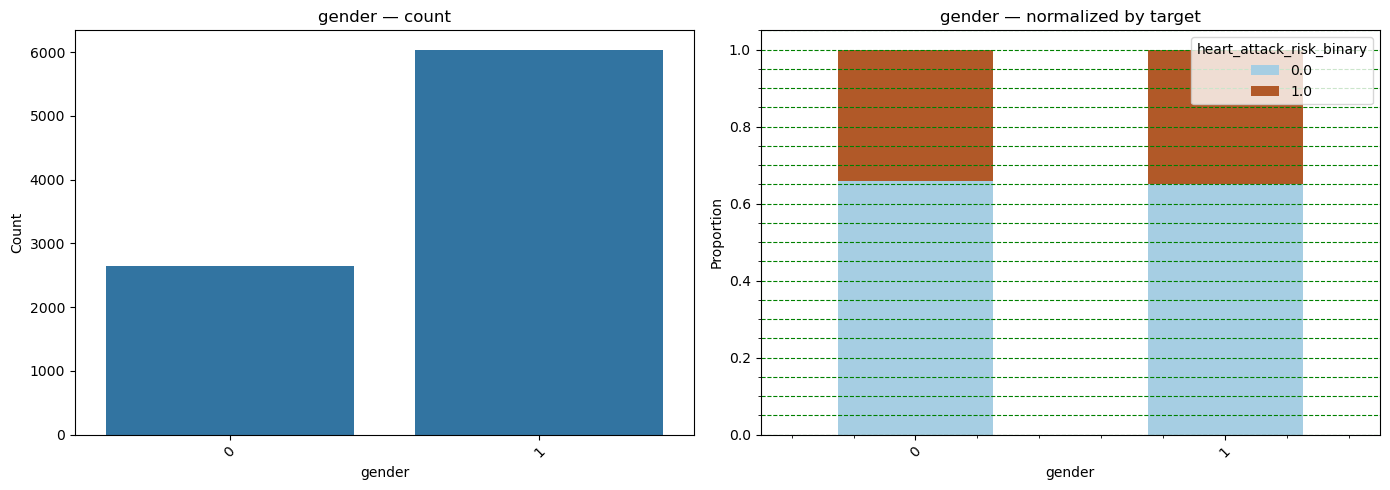

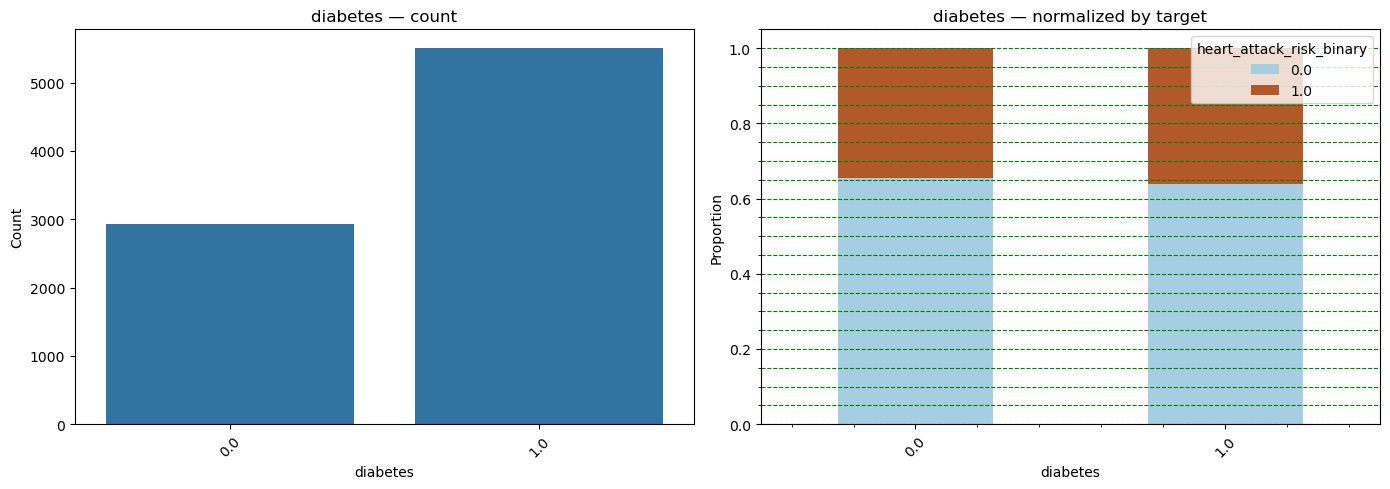

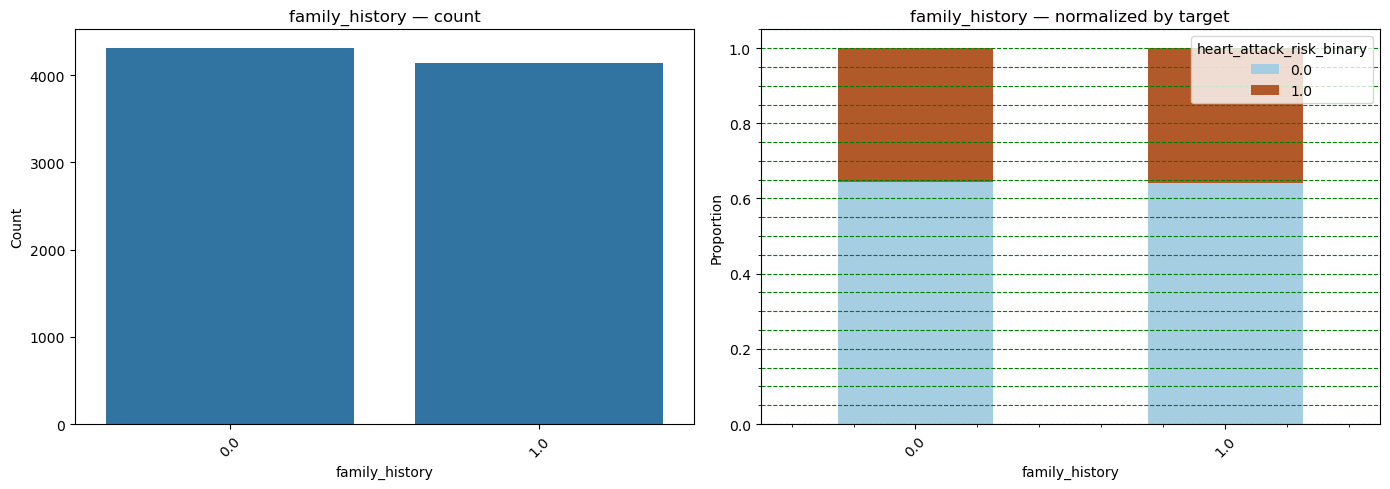

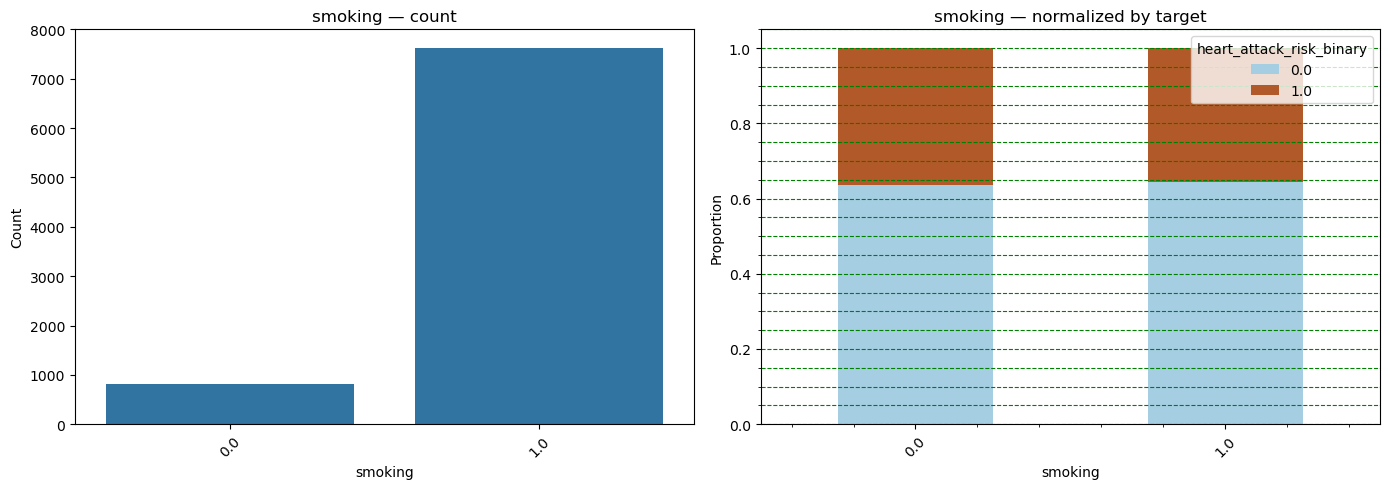

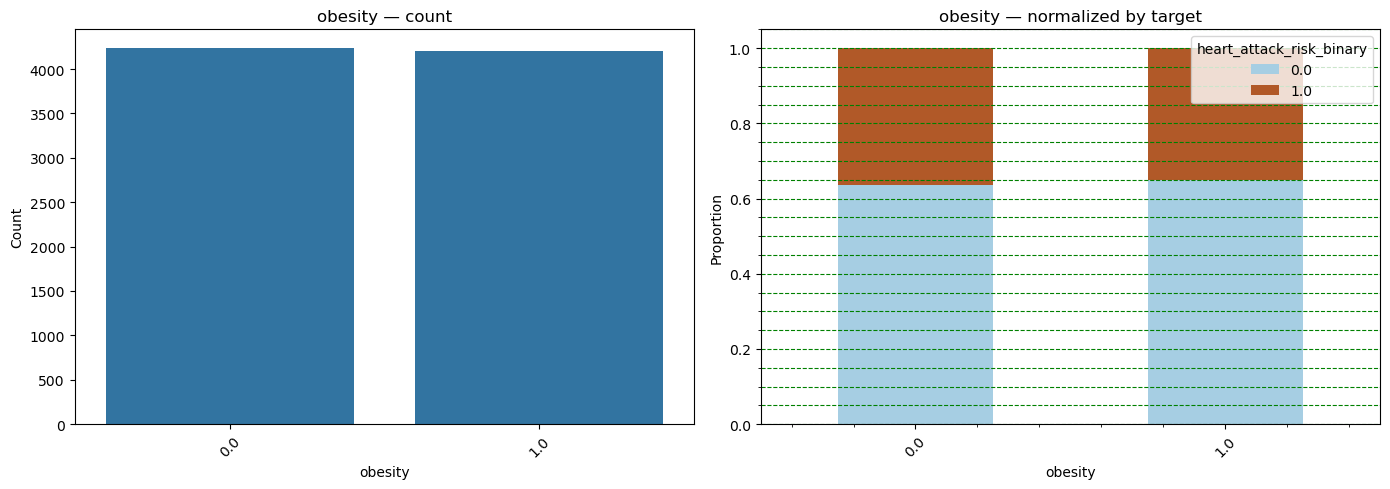

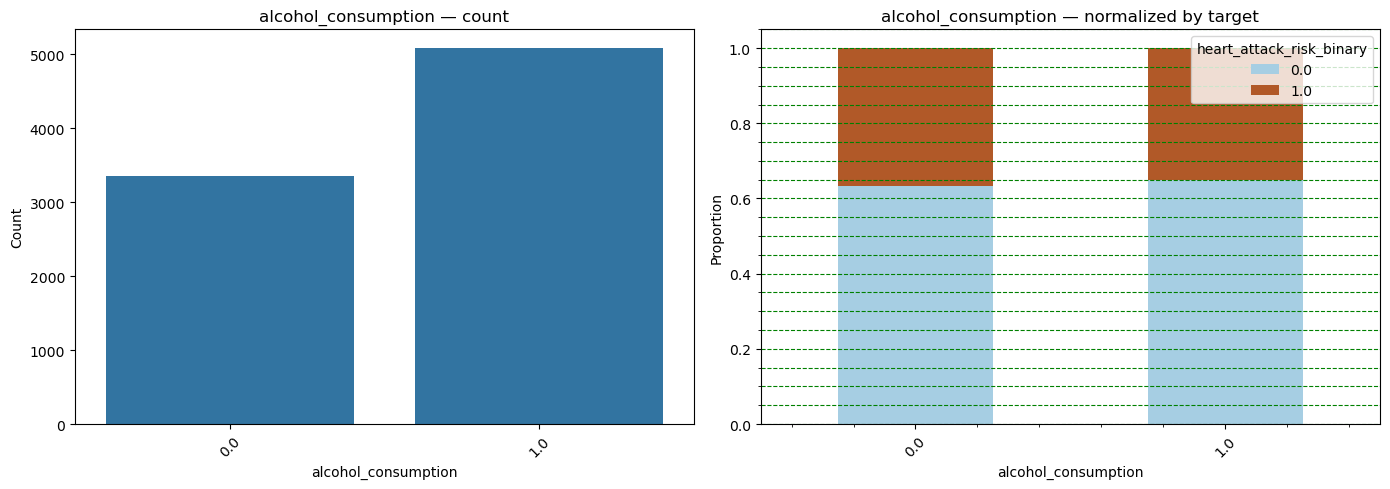

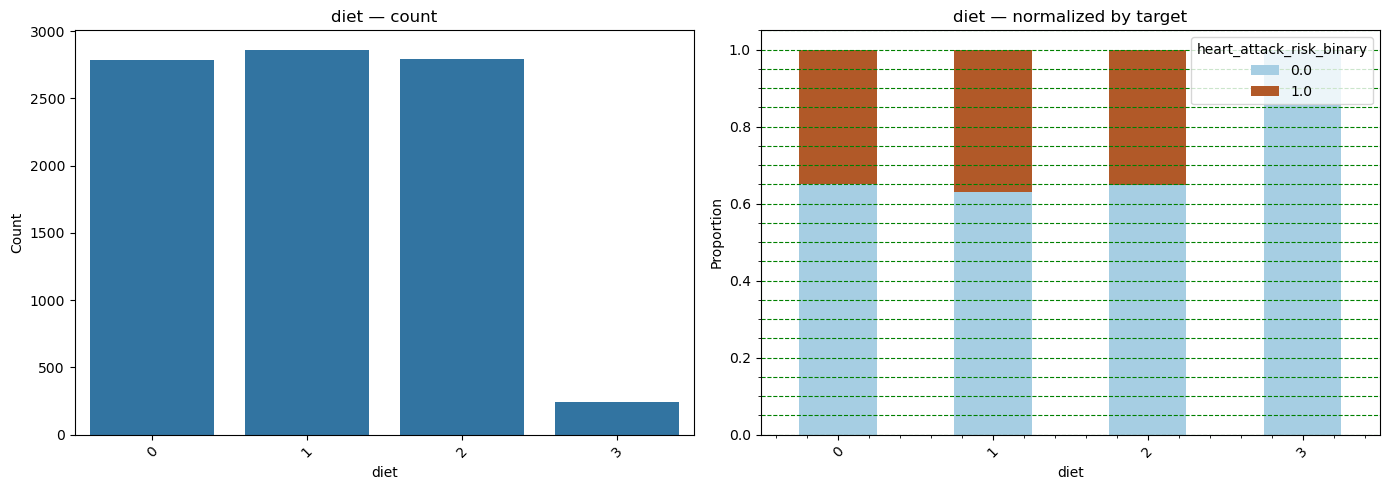

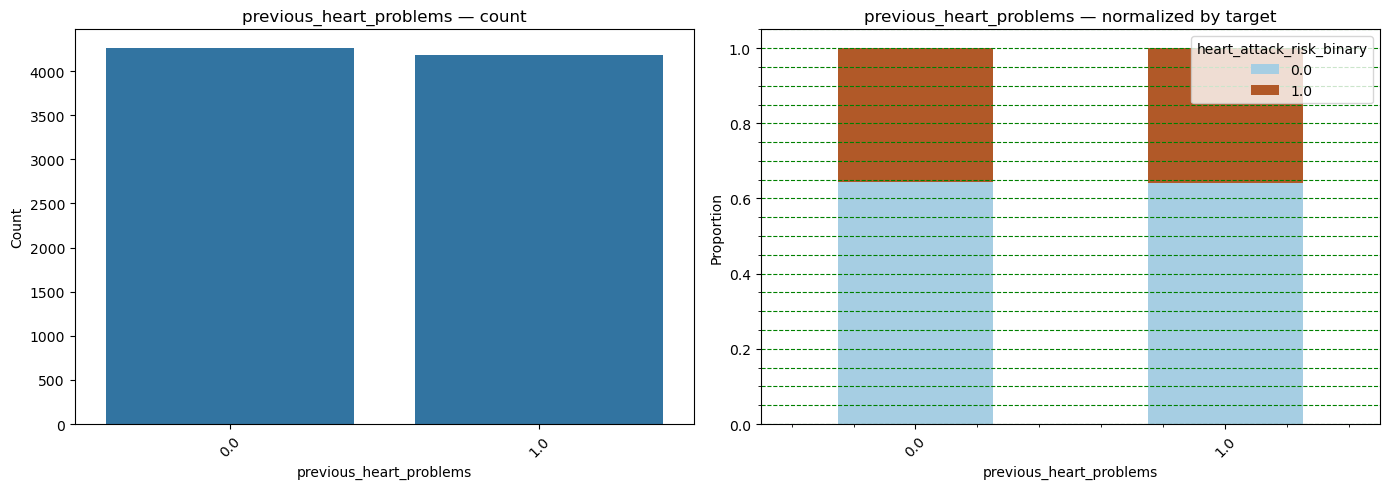

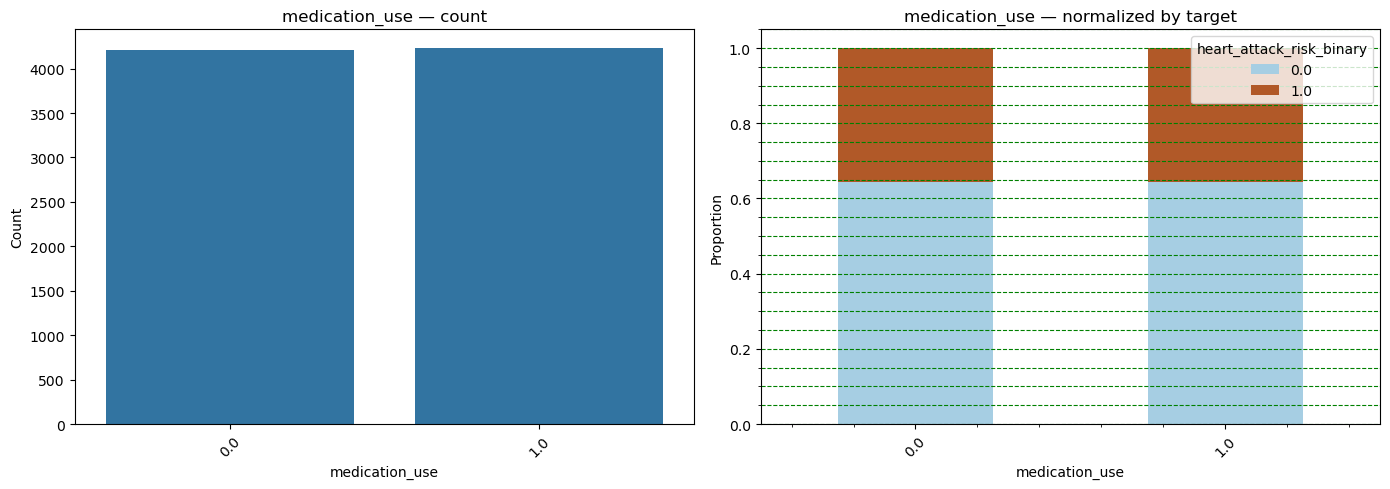

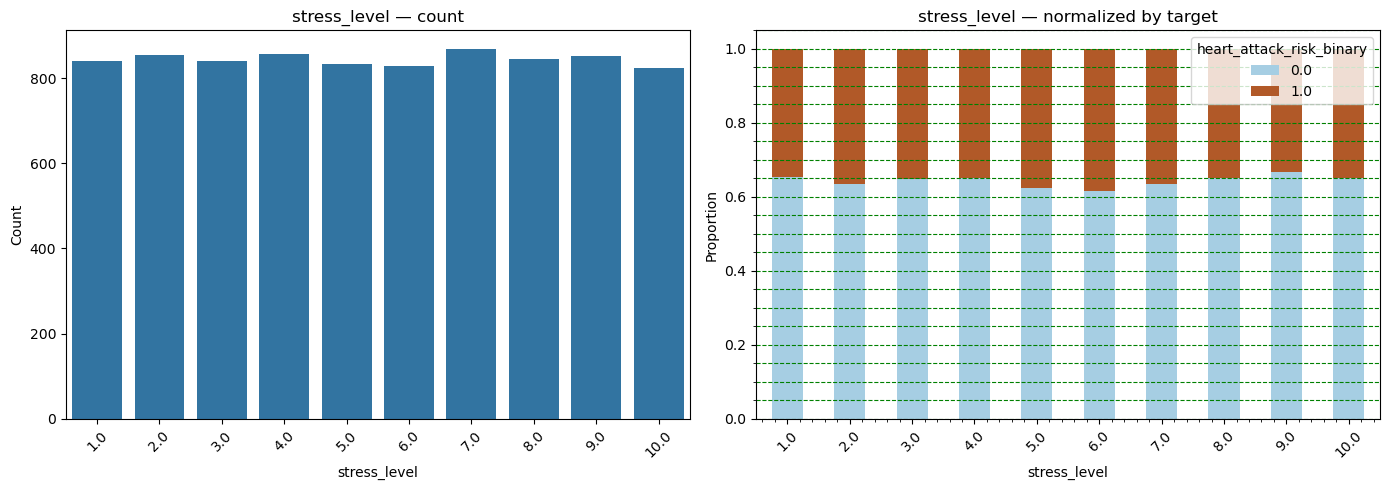

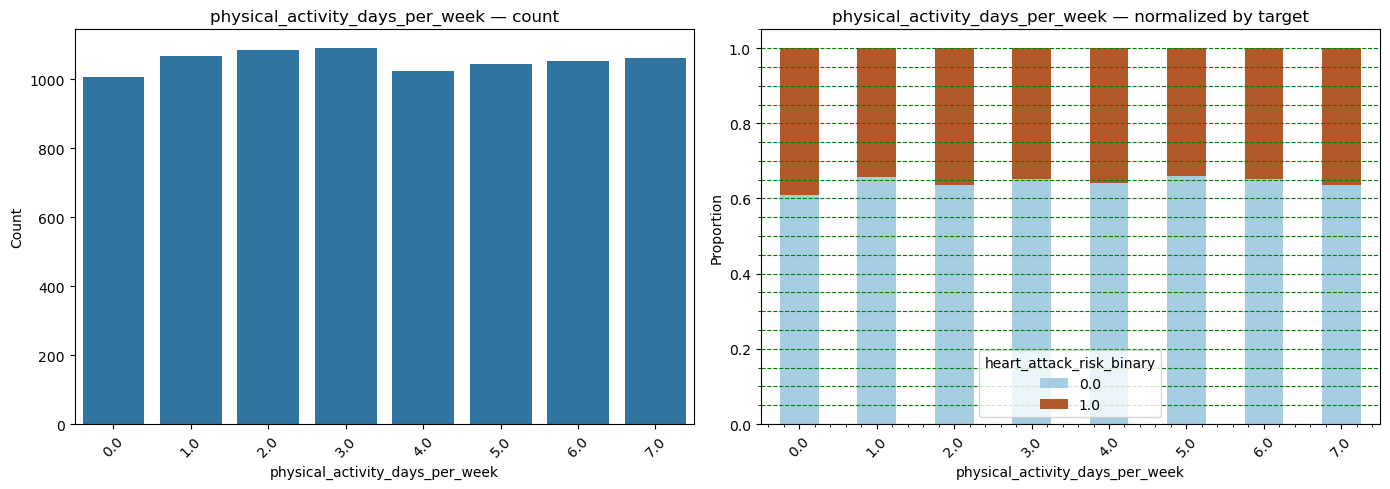

In [29]:
for col in cat_features:
    draw_barplot(train_df_processed, col, target)

Ярко выраженных зависимостей между категориальными признаками и таргетом не наблюдается

 ### Целевой признак

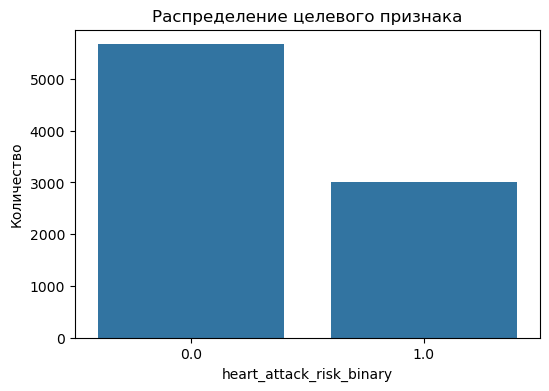

In [30]:
plt.figure(figsize=(6,4))
sns.countplot(data=train_df, x=target)
plt.title('Распределение целевого признака')
plt.xlabel(target)
plt.ylabel('Количество')
plt.show()

In [31]:
train_df[target].mean()

0.34699988483243116

**Наблюдается дисбаланс целевого признака. Доля положительных значений целевого признака составляет 0.347.**

**Ярко выраженных зависимостей между категориальнымми признаками и целевым не наблюдается**

**При анализе числовых признаков обнаружено, что среди пациентов, у которых `bmi`,  `cholesterol`, `exercise_hours_per_week`, `income`, `sedentary_hours_per_day` и `triglycerides` соответствуют определенному узкому диапазону значений, наблюдается более низкая доля сердечных приступов.**

**Удалены две записи с выбросами `heart_rate`**

## Корреляционный анализ

In [32]:
interval_cols = []
for col in train_df_processed[cat_features + num_features + [target]].columns:
    if train_df[col].nunique() > 100:
        print(col, train_df[col].nunique())
        interval_cols.append(col)

blood_sugar 239
bmi 7933
cholesterol 282
exercise_hours_per_week 7933
income 7808
sedentary_hours_per_day 7933
triglycerides 772


In [33]:
corr_matrix = train_df_processed[cat_features + num_features + [target]].phik_matrix(
    interval_cols=interval_cols
)
corr_matrix

,gender,diabetes,family_history,smoking,obesity,alcohol_consumption,diet,previous_heart_problems,medication_use,stress_level,physical_activity_days_per_week,age,blood_sugar,bmi,cholesterol,diastolic_blood_pressure,exercise_hours_per_week,heart_rate,income,sedentary_hours_per_day,systolic_blood_pressure,triglycerides,sleep_hours_per_day,heart_attack_risk_binary
gender,1.000000,0.000000,0.000000,0.703385,0.000000,0.000000,0.007941,0.000000,0.000000,0.006958,0.018975,0.000000,0.000000,0.045868,0.033955,0.058552,0.036369,0.055364,0.013055,0.000000,0.060046,0.059575,0.030310,0.000000
diabetes,0.000000,1.000000,0.025809,0.000000,0.019436,0.000000,0.000000,0.000000,0.000000,0.000000,0.012481,0.044756,0.000000,0.010086,0.033748,0.044894,0.000000,0.000000,0.006288,0.036240,0.100747,0.043154,0.027584,0.018324
family_history,0.000000,0.025809,1.000000,0.000000,0.009305,0.005136,0.000000,0.000000,0.000000,0.024292,0.027124,0.037089,0.027865,0.018612,0.000000,0.061095,0.000000,0.000000,0.033165,0.011677,0.047295,0.000000,0.018189,0.000000
smoking,0.703385,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.596243,0.115593,0.010789,0.025223,0.000000,0.008420,0.042412,0.000000,0.010181,0.049900,0.034906,0.008616,0.000000
obesity,0.000000,0.019436,0.009305,0.000000,1.000000,0.020462,0.000000,0.000000,0.000000,0.037677,0.016269,0.054113,0.000000,0.000000,0.000000,0.039197,0.057019,0.107805,0.000000,0.028106,0.031798,0.005890,0.000000,0.015839
alcohol_consumption,0.000000,0.000000,0.005136,0.000000,0.020462,1.000000,0.000000,0.000000,0.000000,0.000000,0.021965,0.059325,0.000000,0.010931,0.051442,0.047994,0.000000,0.056752,0.027961,0.053899,0.065738,0.025038,0.000000,0.014553
diet,0.007941,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.010985,0.000000,0.000000,0.025646,0.246233,0.259922,0.403324,0.392997,0.469969,0.412027,0.472629,0.412723,0.401252,0.282954,0.406685,0.886625,0.185808
previous_heart_problems,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010985,1.000000,0.013833,0.000000,0.039572,0.000000,0.000000,0.037022,0.000000,0.051345,0.031365,0.067172,0.000000,0.031132,0.057210,0.000000,0.000000,0.000000
medication_use,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.013833,1.000000,0.059446,0.023983,0.000000,0.000000,0.013830,0.000000,0.000000,0.000000,0.000000,0.000000,0.035335,0.065712,0.000000,0.022165,0.000000
stress_level,0.006958,0.000000,0.024292,0.000000,0.037677,0.000000,0.000000,0.000000,0.059446,1.000000,0.033918,0.097021,0.000000,0.082253,0.053361,0.098947,0.058516,0.105021,0.021268,0.031829,0.136984,0.048790,0.025438,0.000000


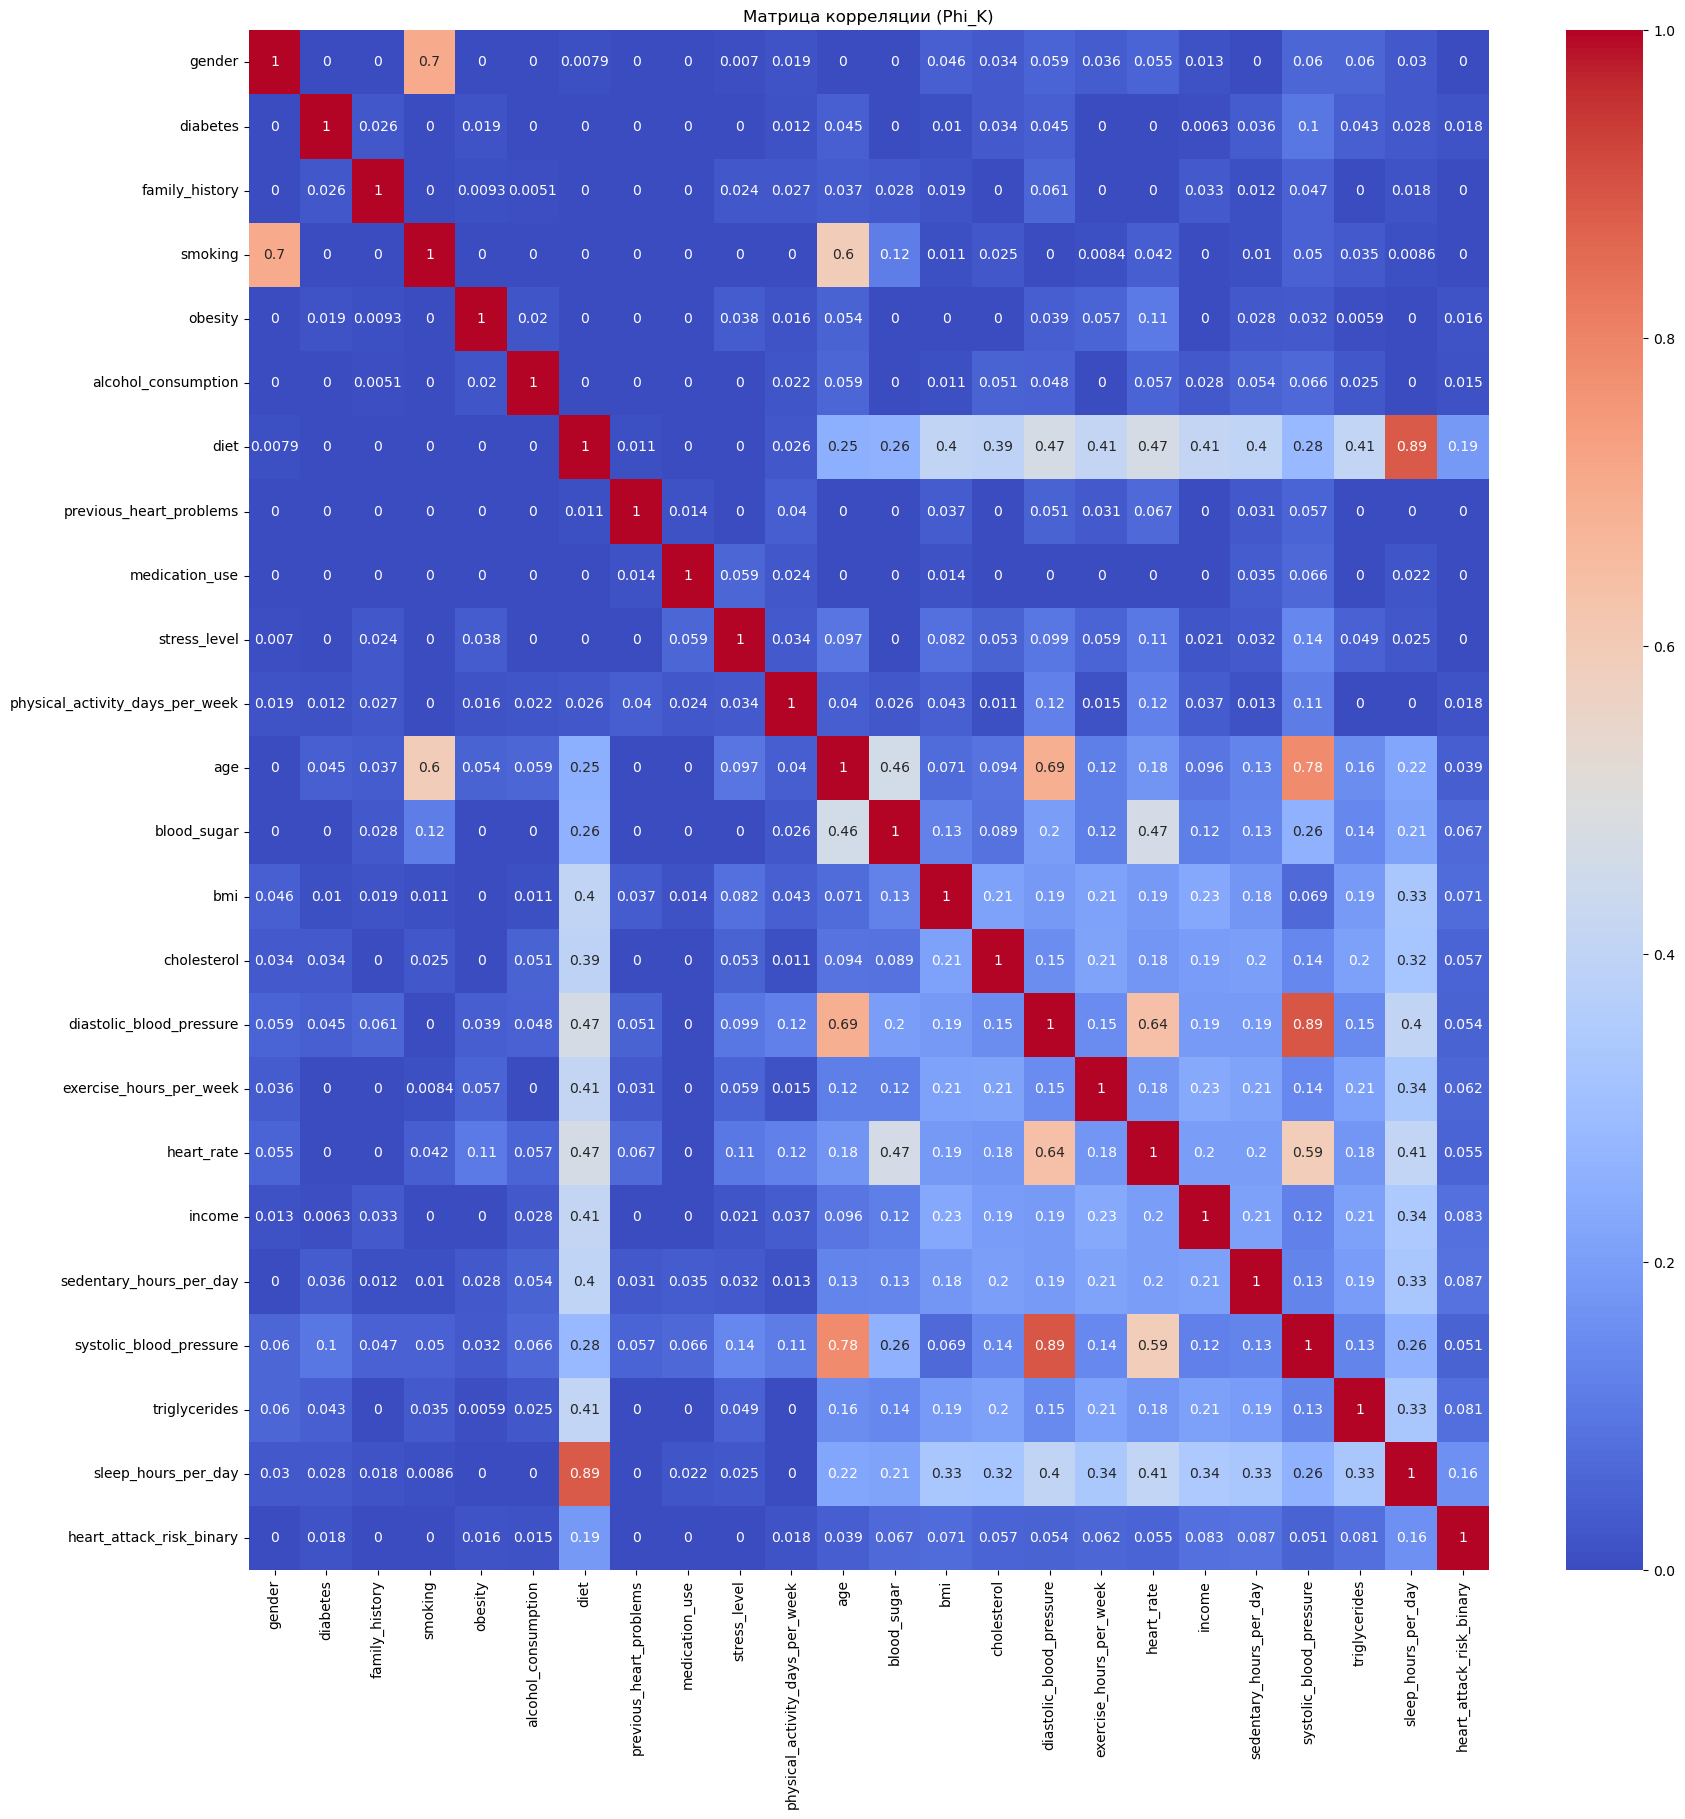

In [34]:
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Матрица корреляции (Phi_K)')
plt.show()

**Мультиколлинеарность не наблюдается.**

**Между целевым и входными признаками корреляция либо не наблюдается, либо очень слабая. Наибольшие значения корреляции с целевым признаком можно увидеть у `diet` и `sleep_hours_per_day` - 0.19 и 0.16 соотвественно.**

## Обучение модели

В задаче предсказания риска сердечного приступа критически важно не пропускать пациентов с реальным высоким риском, однако чрезмерное количество ложных срабатываний также делает модель непрактичной.

В качестве функции оптимизации была выбрана метрика F1-score, поскольку она позволяет обучить модель с балансом между полнотой (recall) и точностью (precision), после чего порог классификации можно дополнительно настроить для максимизации recall.

Создадим класс для препроцессинга входных признаков

In [35]:
class FeaturesPreprocessor:
    def __init__(self, cat_features, num_features):
        self.cat_features = cat_features
        self.num_features = num_features

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        import pandas as pd
        import warnings
        warnings.simplefilter(action='ignore', category=FutureWarning)
        X = X.copy()
        for col in self.cat_features:
            X[col] = X[col].astype(object)
            X[col] = X[col].replace({'Male': 1, 'Female': 0})
            numeric_mask = pd.to_numeric(X[col], errors='coerce').notna()
            X.loc[numeric_mask, col] = pd.to_numeric(X.loc[numeric_mask, col]).astype(int)
            X[col] = X[col].astype(str)
        return X[self.cat_features + self.num_features]  #  срез необходим для корректировки порядка колонок (тогда при экспулатации порядок колонок будет неважен)

Разделим на тренировочную и валидационную выборки

In [36]:
X = train_df[cat_features + num_features]
y = train_df[target]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE)

Создадим пайплайн

In [37]:
pipeline = Pipeline([
    ('preprocessor', FeaturesPreprocessor(cat_features=cat_features, num_features=num_features)),
    ('classifier', CatBoostClassifier(
        iterations=500,
        learning_rate=0.001,
        depth=4,
        l2_leaf_reg=1,
        loss_function='Logloss',
        eval_metric='F1',
        random_seed=RANDOM_STATE,
        verbose=100,
        class_weights=[1, 1.85],
        use_best_model=True
    ))
])
pipeline.fit(
    X_train, y_train,
    classifier__eval_set=(pipeline.named_steps['preprocessor'].transform(X_val), y_val),
    classifier__cat_features=cat_features
)


0:	learn: 0.6424780	test: 0.6438794	best: 0.6438794 (0)	total: 185ms	remaining: 1m 32s
100:	learn: 0.6737961	test: 0.6727923	best: 0.6756467 (35)	total: 2.58s	remaining: 10.2s
200:	learn: 0.6736486	test: 0.6726298	best: 0.6756467 (35)	total: 4.89s	remaining: 7.27s
300:	learn: 0.6741917	test: 0.6726298	best: 0.6756467 (35)	total: 7.3s	remaining: 4.83s
400:	learn: 0.6748647	test: 0.6726298	best: 0.6756467 (35)	total: 9.8s	remaining: 2.42s
499:	learn: 0.6763391	test: 0.6732800	best: 0.6756467 (35)	total: 12.3s	remaining: 0us

bestTest = 0.6756466859
bestIteration = 35

Shrink model to first 36 iterations.


,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False


Рассчитаем метрики

In [38]:
y_pred = pipeline.predict(X_val)

In [39]:
acc = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

print(f"Accuracy: {acc}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

Accuracy: 0.38876093965914327
Precision: 0.3614864864864865
Recall: 0.9946879150066401
F1-score: 0.5302654867256638


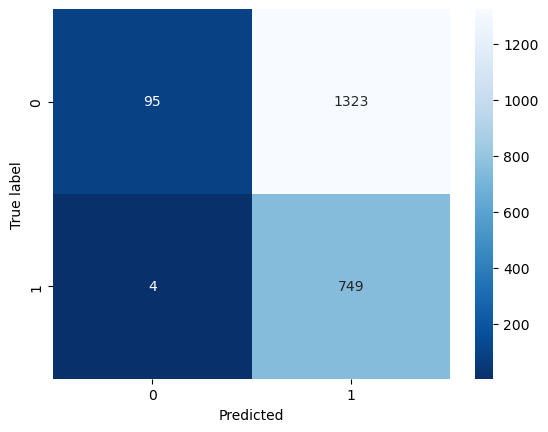

In [40]:
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.ylabel('True label')
plt.xlabel('Predicted')
plt.show()

In [41]:
y_proba = pipeline.predict_proba(X_val)[:, 1]

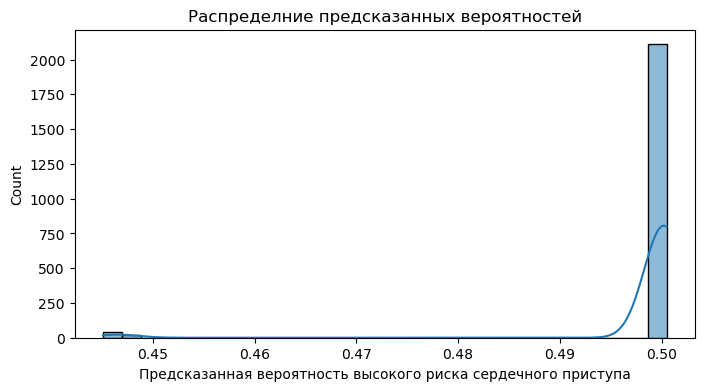

In [42]:
plt.figure(figsize=(8, 4))
sns.histplot(y_proba, bins=30, kde=True)
plt.xlabel('Предсказанная вероятность высокого риска сердечного приступа')
plt.ylabel('Count')
plt.title('Распределние предсказанных вероятностей')
plt.show()

Полученная модель демонстрирует крайне высокую полноту (recall 0.995), что означает практически полное отсутствие пропусков пациентов с реальным высоким риском сердечного приступа.

При этом точность (precision) и accuracy остаются низкими, что указывает на большое количество ложных срабатываний. Однако в данной задаче ложноположительный прогноз менее критичен, чем пропуск пациента с высоким риском.

Так как recall уже находится на максимальном уровне, дополнительная настройка порога классификации не требуется.

Сохраним готовый пайплайн в файл `artifacts/heart_risk_model.pkl`

In [43]:
artifacts_dir = Path('artifacts')
artifacts_dir.mkdir(exist_ok=True)
filename = 'heart_risk_model.pkl'
with open(artifacts_dir / filename, 'wb') as f:
    dill.dump(pipeline, f)

Изучим значимость признаков на результат предсказаний.

In [44]:
model = pipeline.named_steps['classifier']

feature_names = cat_features + num_features

importances = model.get_feature_importance()

feature_importance_df = (
    pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    })
    .sort_values('importance', ascending=False)
    .reset_index(drop=True)
)

display(feature_importance_df)

,feature,importance
0,obesity,30.587352
1,smoking,30.340095
2,family_history,15.143921
3,medication_use,11.267644
4,diabetes,6.913336
5,alcohol_consumption,3.713697
6,age,0.334662
7,bmi,0.282734
8,systolic_blood_pressure,0.280388
9,gender,0.215611


Видим, что наиболее значимы в порядке убывания признаки obesity, smoking, family_history, medication_use, diabetes и alcohol_consumption

**Обученная модель сохранена по пути `artifacts/heart_risk_model.pkl`**

**Метрики модели:**

Accuracy: 0.38876093965914327

Precision: 0.3614864864864865

Recall: 0.9946879150066401

F1-score: 0.5302654867256638

## Вывод

В рамках работы была проведена первичная очистка и анализ данных, выявлены особенности распределений признаков и потенциальные источники утечки целевого признака, которые были исключены из обучения. Данные не содержат дубликатов или выраженной мультиколлинеарности. В выборке присутствует дисбаланс целевого признака.

Для решения задачи была обучена модель классификации CatBoost, выбранная за способность корректно работать с категориальными признаками и пропущенными значениями без дополнительной сложной предобработки. 

Полученная модель демонстрирует крайне высокую полноту (recall ≈ 0.995), что означает практически полное отсутствие пропусков пациентов с реальным высоким риском сердечного приступа. При этом точность и accuracy остаются на невысоком уровне, что указывает на значительное количество ложноположительных прогнозов. Однако с учётом предметной области данное поведение модели является допустимым, поскольку пропуск пациента с высоким риском значительно критичнее ложного срабатывания.

Наиболее значимыми факторами риска, согласно модели, являются ожирение, курение, наследственная предрасположенность, приём медикаментов, диабет и употребление алкоголя, что в целом согласуется с медицинской экспертизой. Обученная модель сохранена по пути `artifacts/heart_risk_model.pkl` и может быть использована для дальнейших экспериментов или внедрения.